# Entry G12b notebook: Degree Comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('once')

from neo4j import GraphDatabase

In [3]:
uri = "bolt://localhost:7687"

driver = GraphDatabase.driver(uri, auth=('neo4j', 'password'))

uni_session = driver.session(database="unimodal")
bi_session = driver.session(database="bimodal")
mix_session = driver.session(database="mixmodal")

## Degree Count

In [4]:
pd.DataFrame(uni_session.run('''MATCH ()-[r]->()
RETURN type(r) as rel_type, count(r) as unimodal''').data()).merge(
pd.DataFrame(bi_session.run('''MATCH ()-[r]->()
RETURN type(r) as rel_type, count(r) as bimodal''').data()), on="rel_type", how='outer').merge(
pd.DataFrame(mix_session.run('''MATCH ()-[r]->()
RETURN type(r) as rel_type, count(r) as mixmodal''').data()), on='rel_type', how='outer').fillna(0)

,rel_type,unimodal,bimodal,mixmodal
0,KNOWS,171644.0,0.0,171644
1,APPEARS_IN,0.0,96104.0,96104


## Degree Summary Statistics

### Unimodal Model

In [21]:
pd.DataFrame(uni_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'pattern_match'}).merge(
pd.DataFrame(uni_session.run('''MATCH (n)
RETURN min(apoc.node.degree(n)) as degree_min,
max(apoc.node.degree(n)) as degree_max,
round(avg(apoc.node.degree(n))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n))*100)/100 as degree_stdev''').data()).transpose().rename(columns={0:'apoc_function'}), right_index=True, left_index=True).merge(
pd.DataFrame(uni_session.run('''CALL gds.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
  KNOWS: {
  type: 'KNOWS',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()).transpose().rename(columns={0:'gds_function'}), right_index=True, left_index=True).merge(
pd.DataFrame(uni_session.run('''MATCH (h)
WITH h.name as hero, size((h)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()).transpose().rename(columns={0:'size_function'}), right_index=True, left_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pattern_match,apoc_function,gds_function,size_function
degree_min,0.00,0.00,0.00,0.00
degree_max,1919.00,1919.00,1919.00,1919.00
degree_avg,53.31,53.31,53.31,53.31
degree_stdev,116.63,116.63,116.63,116.63


### Bimodal Model

#### Direction

To provide consistency between the pattern match option and the `gds` function, I'm including three ways to pull the degree by including (or excluding) information about the direction of the relationship.

- Outgoing relationship
  - Due to the relationship direction in our data, the query only returns c2 results when the start node is a Hero node
  - (:Hero)-[]->(:Comic)
- Incoming relationship
  - Due to the relationship direction in our data, the query only returns c2 results when the start node is a Comic node
  - (:Comic)<-[]-(:Hero)
- Undirected relationship
  - Because there is no constraint regarding the direction of the relationship, the query returns results for c2 regardless of node label
  - (:Hero)-[]-(:Comic)
  - (:Comic)-[]-(:Hero)
  
*Note*, if we fail to include the label in the first `MATCH` statement of the outgoing and incoming relationship queries, all nodes of the other label will return a degree of 0, which effects our average and standard deviation.

This is easiest to see using the pattern match. As such, I have included the correct and incorrect results for incoming and outgoing relationships. This doesn't apply to undirected metrics as all relationships and nodes are counted regardless of direction.

**Outgoing relationship**

In [137]:
pd.DataFrame(bi_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)-[]->(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'incorrect'}).merge(
pd.DataFrame(bi_session.run('''MATCH (c1:Hero)
OPTIONAL MATCH (c1)-[]->(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'correct'}), left_index=True, right_index=True)

,incorrect,correct
degree_min,0.00,1.00
degree_max,1577.00,1577.00
degree_avg,5.03,14.93
degree_stdev,35.14,59.27


**Incoming relationship**

In [141]:
pd.DataFrame(bi_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)<-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'incorrect'}).merge(
pd.DataFrame(bi_session.run('''MATCH (c1:Comic)
OPTIONAL MATCH (c1)<-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'correct'}), left_index=True, right_index=True)

,incorrect,correct
degree_min,0.00,1.00
degree_max,111.00,111.00
degree_avg,5.03,7.60
degree_stdev,6.35,6.44


### Undirected

In [31]:
pd.DataFrame(bi_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'pattern_match'}).merge(
    pd.DataFrame(bi_session.run('''MATCH (n)
RETURN min(apoc.node.degree(n)) as degree_min,
max(apoc.node.degree(n)) as degree_max,
round(avg(apoc.node.degree(n))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n))*100)/100 as degree_stdev''').data()).transpose().rename(columns={0:'apoc_function'}), left_index=True, right_index=True).merge(
    pd.DataFrame(bi_session.run('''CALL gds.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()).transpose().rename(columns = {0:'gds_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(bi_session.run('''MATCH (n)
WITH n.name as name, size((n)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'size_function'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pattern_match,apoc_function,gds_function,size_function
degree_min,1.00,1.00,1.00,1.00
degree_max,1577.00,1577.00,1577.00,1577.00
degree_avg,10.07,10.07,10.07,10.07
degree_stdev,34.99,34.99,34.99,34.99


### Hero to Comic

In [92]:
pd.DataFrame(bi_session.run('''MATCH (c1:Hero)
OPTIONAL MATCH (c1)-[]->(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data(
)).transpose().rename(columns = {0:'pattern_match'}).merge(
pd.DataFrame(bi_session.run('''MATCH (n:Hero)
RETURN min(apoc.node.degree(n, "APPEARS_IN>")) as degree_min,
max(apoc.node.degree(n, "APPEARS_IN>")) as degree_max,
round(avg(apoc.node.degree(n, "APPEARS_IN>"))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n, "APPEARS_IN>"))*100)/100 as degree_stdev''').data(
)).transpose().rename(columns = {0:'apoc_function'}), right_index=True, left_index=True).merge(
pd.DataFrame(bi_session.run('''MATCH (h:Hero)
WITH h.name as hero, size((h)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'size_function'}), right_index=True, left_index=True).merge(
pd.DataFrame(bi_session.run('''CALL gds.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'NATURAL'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data(
)).transpose().rename(columns = {0:'gds_function'}), right_index=True, left_index=True).merge(
pd.DataFrame(bi_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)-[]->(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'incorrect_pm'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pattern_match,apoc_function,size_function,gds_function,incorrect_pm
degree_min,1.00,1.00,1.00,0.00,0.00
degree_max,1577.00,1577.00,1577.00,1577.00,1577.00
degree_avg,14.93,14.93,14.93,5.03,5.03
degree_stdev,59.27,59.27,59.27,35.14,35.14


### Comic to Hero

In [91]:
pd.DataFrame(bi_session.run('''MATCH (c1:Comic)
OPTIONAL MATCH (c1)<-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'pattern_match'}).merge(
    pd.DataFrame(bi_session.run('''MATCH (n:Comic)
RETURN min(apoc.node.degree(n, "<APPEARS_IN")) as degree_min,
max(apoc.node.degree(n, "<APPEARS_IN")) as degree_max,
round(avg(apoc.node.degree(n, "<APPEARS_IN"))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n, "<APPEARS_IN"))*100)/100 as degree_stdev''').data(
)).transpose().rename(columns={0:'apoc_function'}), right_index=True, left_index=True).merge(
pd.DataFrame(bi_session.run('''MATCH (c:Comic)
WITH c.name as comic, size((c)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'size_function'}), left_index=True, right_index=True).merge(
    pd.DataFrame(bi_session.run('''CALL gds.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'REVERSE'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data(
    )).transpose().rename(columns = {0:'gds_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(bi_session.run('''MATCH (c1)
OPTIONAL MATCH (c1)<-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree), 2) as degree_avg,
round(stDev(degree), 2) as degree_stdev
''').data()).transpose().rename(columns={0:'incorrect_pm'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pattern_match,apoc_function,size_function,gds_function,incorrect_pm
degree_min,1.00,1.00,1.00,0.00,0.00
degree_max,111.00,111.00,111.00,111.00,111.00
degree_avg,7.60,7.60,7.60,5.03,5.03
degree_stdev,6.44,6.44,6.44,6.35,6.35


### Hero to Hero

In [136]:
pd.DataFrame(bi_session.run('''MATCH (h1:Hero)
OPTIONAL MATCH (h1)-[]->(c)<-[]-(h2)
WITH h1, count(distinct h2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'pattern_match'}).merge(
pd.DataFrame(bi_session.run('''MATCH (h:Hero)
WITH h.name as hero, size((h)-->(:Comic)<--(:Hero)) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'size_function'}), left_index=True, right_index=True)

,pattern_match,size_function
degree_min,0.00,0.00
degree_max,1919.00,16057.00
degree_avg,53.31,179.89
degree_stdev,116.63,727.36


## Mixed Model

### All Undirected

In [4]:
pd.DataFrame(mix_session.run('''MATCH (c1)-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'pattern_match'}).merge(
pd.DataFrame(mix_session.run('''MATCH (n)
RETURN min(apoc.node.degree(n)) as degree_min,
max(apoc.node.degree(n)) as degree_max,
round(avg(apoc.node.degree(n))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'apoc_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''CALL gds.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: ['KNOWS', 'APPEARS_IN']
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS name, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'gds_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (n)
WITH n.name as name, size((n)--()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'size_function'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pattern_match,apoc_function,gds_function,size_function
degree_min,1.00,1.00,0.00,1.00
degree_max,3331.00,3331.00,3004.00,3331.00
degree_avg,28.05,28.05,14.03,28.05
degree_stdev,104.42,104.42,71.98,104.42


### Hero to Comic and Comic to Hero (`APPEARS_IN` undirected)

In [5]:
pd.DataFrame(mix_session.run('''MATCH (c1)-[:APPEARS_IN]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'pattern_match'}).merge(
pd.DataFrame(mix_session.run('''MATCH (n)
RETURN min(apoc.node.degree(n, "APPEARS_IN")) as degree_min,
max(apoc.node.degree(n, "APPEARS_IN")) as degree_max,
round(avg(apoc.node.degree(n, "APPEARS_IN"))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n, "APPEARS_IN"))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'apoc_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''CALL gds.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'gds_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (h)
WITH h.name as hero, size((h)-[:APPEARS_IN]-()) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'size_function'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pattern_match,apoc_function,gds_function,size_function
degree_min,1.00,1.00,1.00,1.00
degree_max,1577.00,1577.00,1577.00,1577.00
degree_avg,10.07,10.07,10.07,10.07
degree_stdev,34.99,34.99,34.99,34.99


### Hero to Hero (`KNOWS` undirected)

In [6]:
pd.DataFrame(mix_session.run('''MATCH (c1)-[:KNOWS]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'pattern_match'}).merge(
pd.DataFrame(mix_session.run('''MATCH (n:Hero)
RETURN min(apoc.node.degree(n, "KNOWS")) as degree_min,
max(apoc.node.degree(n, "KNOWS")) as degree_max,
round(avg(apoc.node.degree(n, "KNOWS"))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n, "KNOWS"))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'apoc_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''CALL gds.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
  APPEARS_IN: {
  type: 'KNOWS',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'gds_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (h:Hero)
WITH h.name as hero, size((h)--(:Hero)) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'size_function'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pattern_match,apoc_function,gds_function,size_function
degree_min,1.00,0.00,0.00,0.00
degree_max,1919.00,1919.00,1919.00,1919.00
degree_avg,53.46,53.31,53.31,53.31
degree_stdev,116.76,116.63,116.63,116.63


### Hero to Comic

In [7]:
pd.DataFrame(mix_session.run('''MATCH (c1:Hero)-[:APPEARS_IN]->(c2:Comic)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'pattern_match'}).merge(
pd.DataFrame(mix_session.run('''MATCH (n:Hero)
RETURN min(apoc.node.degree(n, "APPEARS_IN>")) as degree_min,
max(apoc.node.degree(n, "APPEARS_IN>")) as degree_max,
round(avg(apoc.node.degree(n, "APPEARS_IN>"))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n, "APPEARS_IN>"))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'apoc_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''CALL gds.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'NATURAL'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'gds_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (h:Hero)
WITH h.name as hero, size((h)--(:Comic)) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'size_function'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pattern_match,apoc_function,gds_function,size_function
degree_min,1.00,1.00,0.00,1.00
degree_max,1577.00,1577.00,1577.00,1577.00
degree_avg,14.93,14.93,5.03,14.93
degree_stdev,59.27,59.27,35.14,59.27


### Comic to Hero

In [8]:
pd.DataFrame(mix_session.run('''MATCH (c1:Comic)<-[:APPEARS_IN]-(c2:Hero)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree),2) as degree_avg,
round(stDev(degree),2) as degree_stdev
''').data()).transpose().rename(columns = {0:'comic to hero'}).merge(
pd.DataFrame(mix_session.run('''MATCH (n:Comic)
RETURN min(apoc.node.degree(n, "<APPEARS_IN")) as degree_min,
max(apoc.node.degree(n, "<APPEARS_IN")) as degree_max,
round(avg(apoc.node.degree(n, "<APPEARS_IN"))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n, "<APPEARS_IN"))*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'comic to any'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''CALL gds.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'REVERSE'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'gds_function'}), left_index=True, right_index=True).merge(
pd.DataFrame(mix_session.run('''MATCH (c:Comic)
WITH c.name as comic, size((c)--(:Hero)) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev
''').data()).transpose().rename(columns = {0:'size_function'}), left_index=True, right_index=True)

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comic to hero,comic to any,gds_function,size_function
degree_min,1.00,1.00,0.00,1.00
degree_max,111.00,111.00,111.00,111.00
degree_avg,7.60,7.60,5.03,7.60
degree_stdev,6.44,6.44,6.35,6.44


## Degree Distribution

In [125]:
uni_degree_df = pd.DataFrame(uni_session.run('''CALL gds.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
  KNOWS: {
  type: 'KNOWS',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS hero, score AS degree
''').values(), columns=['hero', 'degree'])
uni_degree_df.head()

,hero,degree
0,24-HOUR MAN/EMMANUEL,5.0
1,3-D MAN/CHARLES CHAN,122.0
2,4-D MAN/MERCURIO,72.0
3,8-BALL/,14.0
4,"ABBOTT, JACK",8.0


In [143]:
print('min:', uni_degree_df['degree'].min())
print('max:', uni_degree_df['degree'].max())
print('mean:', uni_degree_df['degree'].mean())
print('standard deviation:', uni_degree_df['degree'].std())

min: 0.0
max: 1919.0
mean: 53.31386861313869
standard deviation: 116.62615859454611


In [126]:
bi_degree_df = pd.DataFrame(bi_session.run('''CALL gds.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score AS degree, labels(gds.util.asNode(nodeId))[0] as type
''').values(), columns=['hero', 'degree', 'type'])
bi_degree_df.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hero,degree,type
0,24-HOUR MAN/EMMANUEL,1.0,Hero
1,AA2 35,6.0,Comic
2,3-D MAN/CHARLES CHAN,9.0,Hero
3,AVF 4,11.0,Comic
4,AVF 5,11.0,Comic


In [144]:
#Undirected
print('min:', bi_degree_df['degree'].min())
print('max:', bi_degree_df['degree'].max())
print('mean:', bi_degree_df['degree'].mean())
print('standard deviation:', bi_degree_df['degree'].std())

min: 1.0
max: 1577.0
mean: 10.068517548454688
standard deviation: 34.98865384074356


In [152]:
#Hero to comic
print('min:', bi_degree_df.loc[bi_degree_df['type']=='Hero', 'degree'].min())
print('max:', bi_degree_df.loc[bi_degree_df['type']=='Hero', 'degree'].max())
print('mean:', bi_degree_df.loc[bi_degree_df['type']=='Hero', 'degree'].mean())
print('standard deviation:', bi_degree_df.loc[bi_degree_df['type']=='Hero', 'degree'].std())

min: 1.0
max: 1577.0
mean: 14.925298959465756
standard deviation: 59.26872510194186


In [153]:
#Comic to hero
print('min:', bi_degree_df.loc[bi_degree_df['type']=='Comic', 'degree'].min())
print('max:', bi_degree_df.loc[bi_degree_df['type']=='Comic', 'degree'].max())
print('mean:', bi_degree_df.loc[bi_degree_df['type']=='Comic', 'degree'].mean())
print('standard deviation:', bi_degree_df.loc[bi_degree_df['type']=='Comic', 'degree'].std())

min: 1.0
max: 111.0
mean: 7.596553632123943
standard deviation: 6.4384394651277


In [160]:
bi_degree_h2h = pd.DataFrame(bi_session.run('''MATCH (h1:Hero)
OPTIONAL MATCH (h1)-[]->(c)<-[]-(h2)
WITH h1, count(distinct h2) as degree
RETURN h1.name, degree
''').values(), columns=['hero', 'degree'])

bi_degree_h2h.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hero,degree
0,24-HOUR MAN/EMMANUEL,5
1,3-D MAN/CHARLES CHAN,122
2,4-D MAN/MERCURIO,72
3,8-BALL/,14
4,"ABBOTT, JACK",8


In [162]:
#Hero to Hero
print('min:', bi_degree_h2h['degree'].min())
print('max:', bi_degree_h2h['degree'].max())
print('mean:', bi_degree_h2h['degree'].mean())
print('standard deviation:', bi_degree_h2h['degree'].std())

min: 0
max: 1919
mean: 53.31386861313869
standard deviation: 116.62615859454611


In [127]:
mixed_all = pd.DataFrame(mix_session.run('''MATCH (n)
RETURN n.name as name, size((n)--()) as degree''').data())
mixed_all.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,degree
0,24-HOUR MAN/EMMANUEL,6
1,AA2 35,6
2,3-D MAN/CHARLES CHAN,131
3,AVF 4,11
4,AVF 5,11


In [128]:
mixed_hero2hero = pd.DataFrame(mix_session.run('''MATCH (h:Hero)
RETURN h.name as hero, size((h)--(:Hero)) as degree''').data())
mixed_hero2hero.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hero,degree
0,24-HOUR MAN/EMMANUEL,5
1,3-D MAN/CHARLES CHAN,122
2,4-D MAN/MERCURIO,72
3,8-BALL/,14
4,"ABBOTT, JACK",8


In [129]:
mixed_hero2comic= pd.DataFrame(mix_session.run('''MATCH (h:Hero)
RETURN h.name as hero, size((h)--(:Comic)) as degree''').data())
mixed_hero2comic.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hero,degree
0,24-HOUR MAN/EMMANUEL,1
1,3-D MAN/CHARLES CHAN,9
2,4-D MAN/MERCURIO,9
3,8-BALL/,3
4,"ABBOTT, JACK",1


In [130]:
mixed_comic2hero= pd.DataFrame(mix_session.run('''MATCH (c:Comic)
RETURN c.name as comic, size((c)--(:Hero)) as degree''').data())
mixed_comic2hero.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comic,degree
0,AA2 35,6
1,AVF 4,11
2,AVF 5,11
3,COC 1,111
4,H2 251,8


## Undirected

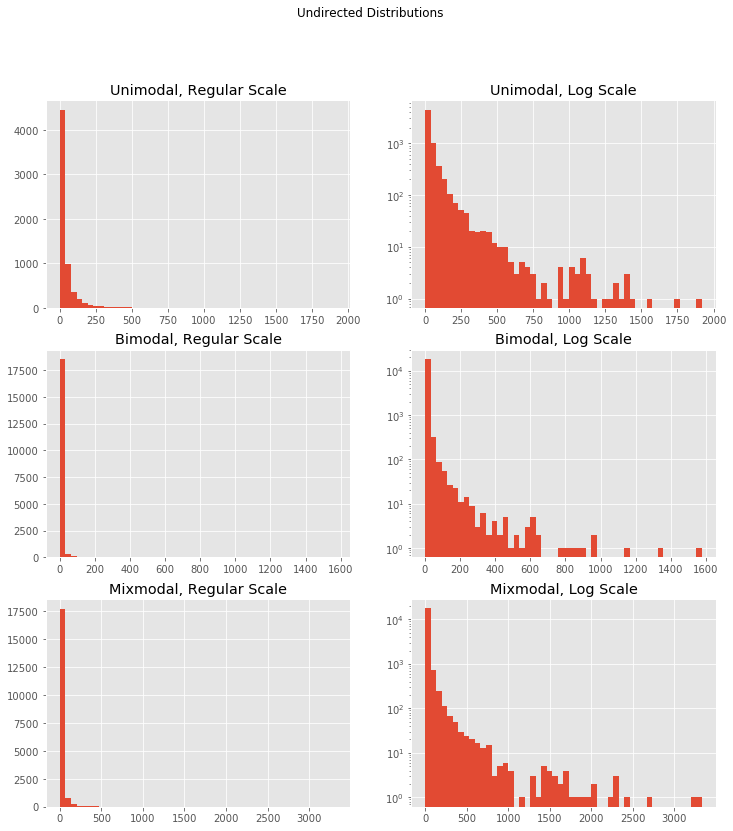

In [170]:
ud_fig, ud_axes = plt.subplots(3, 2, figsize=(12,13))
ud_fig.suptitle("Undirected Distributions")
ud_axes[0,0].hist(uni_degree_df['degree'], bins=50)
ud_axes[0,0].set_title('Unimodal, Regular Scale')
ud_axes[0,1].hist(uni_degree_df['degree'], bins=50)
ud_axes[0,1].set_yscale('log')
ud_axes[0,1].set_title('Unimodal, Log Scale')
ud_axes[1,0].hist(bi_degree_df['degree'], bins=50)
ud_axes[1,0].set_title('Bimodal, Regular Scale')
ud_axes[1,1].hist(bi_degree_df['degree'], bins=50)
ud_axes[1,1].set_yscale('log')
ud_axes[1,1].set_title('Bimodal, Log Scale')
ud_axes[2,0].hist(mixed_all['degree'], bins=50)
ud_axes[2,0].set_title('Mixmodal, Regular Scale')
ud_axes[2,1].hist(mixed_all['degree'], bins=50)
ud_axes[2,1].set_yscale('log')
ud_axes[2,1].set_title('Mixmodal, Log Scale')
plt.show()

## Hero to Hero

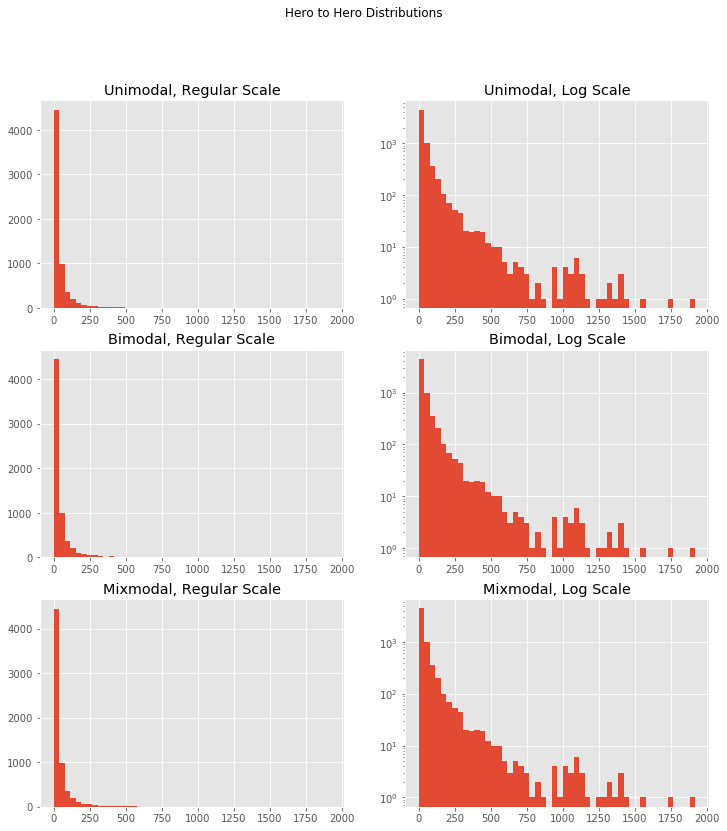

In [171]:
h2h_fig, h2h_axes = plt.subplots(3, 2, figsize=(12,13))
h2h_fig.suptitle("Hero to Hero Distributions")
h2h_axes[0,0].hist(uni_degree_df['degree'], bins=50)
h2h_axes[0,0].set_title('Unimodal, Regular Scale')
h2h_axes[0,1].hist(uni_degree_df['degree'], bins=50)
h2h_axes[0,1].set_yscale('log')
h2h_axes[0,1].set_title('Unimodal, Log Scale')
h2h_axes[1,0].hist(bi_degree_h2h['degree'], bins=50)
h2h_axes[1,0].set_title('Bimodal, Regular Scale')
h2h_axes[1,1].hist(bi_degree_h2h['degree'], bins=50)
h2h_axes[1,1].set_yscale('log')
h2h_axes[1,1].set_title('Bimodal, Log Scale')
h2h_axes[2,0].hist(mixed_hero2hero['degree'], bins=50)
h2h_axes[2,0].set_title('Mixmodal, Regular Scale')
h2h_axes[2,1].hist(mixed_hero2hero['degree'], bins=50)
h2h_axes[2,1].set_yscale('log')
h2h_axes[2,1].set_title('Mixmodal, Log Scale')
plt.show()

## Hero to Comic

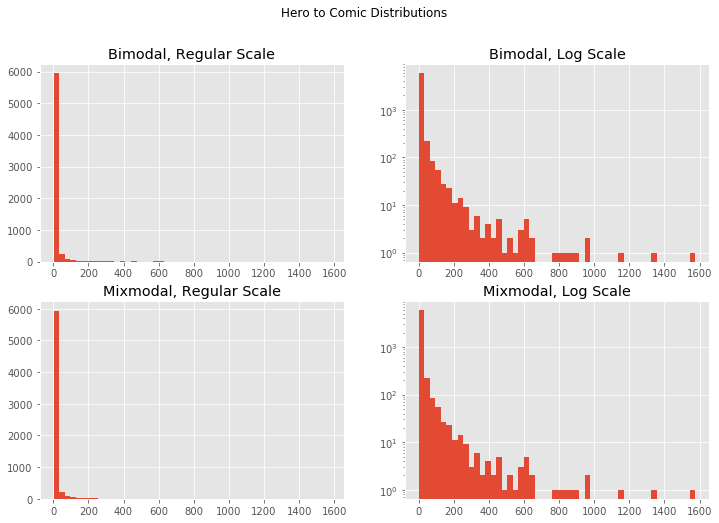

In [174]:
h2c_fig, h2c_axes = plt.subplots(2, 2, figsize=(12,8))
h2c_fig.suptitle("Hero to Comic Distributions")
h2c_axes[0,0].hist(bi_degree_df.loc[bi_degree_df['type']=='Hero', 'degree'], bins=50)
h2c_axes[0,0].set_title('Bimodal, Regular Scale')
h2c_axes[0,1].hist(bi_degree_df.loc[bi_degree_df['type']=='Hero', 'degree'], bins=50)
h2c_axes[0,1].set_yscale('log')
h2c_axes[0,1].set_title('Bimodal, Log Scale')
h2c_axes[1,0].hist(mixed_hero2comic['degree'], bins=50)
h2c_axes[1,0].set_title('Mixmodal, Regular Scale')
h2c_axes[1,1].hist(mixed_hero2comic['degree'], bins=50)
h2c_axes[1,1].set_yscale('log')
h2c_axes[1,1].set_title('Mixmodal, Log Scale')
plt.show()

## Comic to Hero

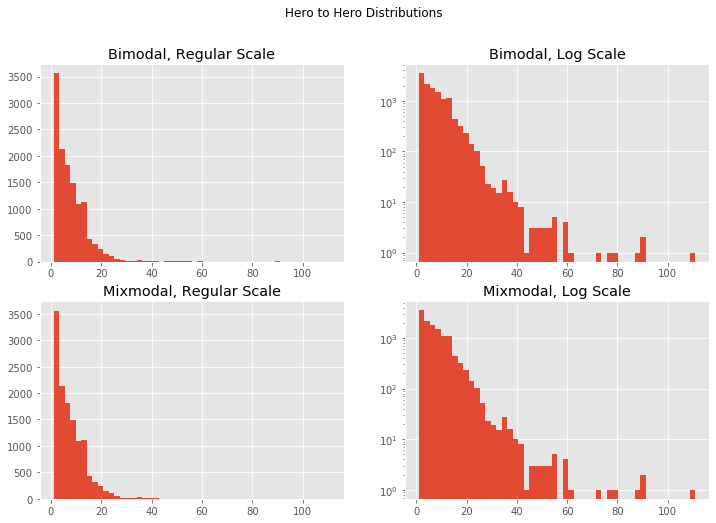

In [175]:
c2h_fig, c2h_axes = plt.subplots(2, 2, figsize=(12,8))
c2h_fig.suptitle("Hero to Hero Distributions")
c2h_axes[0,0].hist(bi_degree_df.loc[bi_degree_df['type']=='Comic', 'degree'], bins=50)
c2h_axes[0,0].set_title('Bimodal, Regular Scale')
c2h_axes[0,1].hist(bi_degree_df.loc[bi_degree_df['type']=='Comic', 'degree'], bins=50)
c2h_axes[0,1].set_yscale('log')
c2h_axes[0,1].set_title('Bimodal, Log Scale')
c2h_axes[1,0].hist(mixed_comic2hero['degree'], bins=50)
c2h_axes[1,0].set_title('Mixmodal, Regular Scale')
c2h_axes[1,1].hist(mixed_comic2hero['degree'], bins=50)
c2h_axes[1,1].set_yscale('log')
c2h_axes[1,1].set_title('Mixmodal, Log Scale')
plt.show()